In [4]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torchvision.utils import make_grid
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as display
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
import copy

## setting device and getting data

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

sys.path.append("../")
from covidct.dataset import *

path = '../data/'

# train_dir='../input/covid19-chest-ct-image-augmentation-gan-dataset/COVID-19/COVID-19/train'

# train_dataset = datasets.ImageFolder(
#     train_dir,
#     transforms.Compose([transforms.Resize( (256,256)) ,
#         transforms.ToTensor(),
#     ]))

## helper functions

In [48]:
def show_image(image_tensor, num_images=25, size=(1, 28, 28)):
    '''
    Function for visualizing images: Given a tensor of images, number of images, and
    size per image, plots and prints the images in an uniform grid.
    '''
    plt.figure(figsize = (4,4))
    image_tensor = (image_tensor + 1) / 2
    image_unflat = image_tensor.detach().cpu()
    image_grid = make_grid(image_unflat[:num_images], nrow=5)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

def plot_loss(training_loss, settings):
    fig, ax = plt.subplots()
    ax.plot(range(len(training_loss)), training_loss)

    ax.set(xlabel='epochs', ylabel='BCE loss')
    ax.set_title(f'Loss for {settings}', y=1.1)
    ax.grid()

    fig.savefig("test.png")
    plt.show()

## creating archistecture

In [7]:
class Encoder(nn.Module):
    '''encoder for VAE, goes from image conv net to linear latent layer'''
    def __init__(self, capacity, latent_dims):
        super(Encoder, self).__init__()
        c = capacity
        self.conv1 = nn.Conv2d(in_channels = 3, out_channels = c, kernel_size = 4, stride = 2, padding = 1)
        self.conv2 = nn.Conv2d(in_channels = c, out_channels = c*2, kernel_size = 4, stride = 2, padding = 1)
        self.conv3 = nn.Conv2d(in_channels = c*2, out_channels = c*2*2, kernel_size = 4, stride = 2, padding = 1)
        self.conv4 = nn.Conv2d(in_channels = c*2*2, out_channels = c*2*2*2, kernel_size = 4, stride = 2, padding = 1)
        self.conv5 = nn.Conv2d(in_channels = c*2*2*2, out_channels = c*2*2*2*2, kernel_size = 4, stride = 2, padding = 1)
        self.conv6 = nn.Conv2d(in_channels = c*2*2*2*2, out_channels = c*2*2*2*2*2, kernel_size = 4, stride = 2, padding = 1)
        self.fc_mu = nn.Linear(in_features = 32768, out_features = latent_dims)
        self.fc_logvar = nn.Linear(in_features = 32768, out_features = latent_dims)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = F.relu(self.conv5(x))
        x = F.relu(self.conv6(x))
        x = x.view(x.size(0), -1) # flatten feature maps to feature vectors for linear layers
        x_mu = self.fc_mu(x)
        x_logvar = self.fc_logvar(x)
        return x_mu, x_logvar

class Decoder(nn.Module):
    '''decoder for VAE, goes from linear latent layer to deconv layers to reconstruct image'''
    def __init__(self, capacity, latent_dims):
        super(Decoder, self).__init__()
        c = capacity
        self.fc = nn.Linear(in_features = latent_dims, out_features = 32768)
        self.conv1 = nn.ConvTranspose2d(in_channels = c, out_channels = 3, kernel_size=4, stride=2, padding=1)
        self.conv2 = nn.ConvTranspose2d(out_channels = c, in_channels = c*2, kernel_size = 4, stride = 2, padding = 1)
        self.conv3 = nn.ConvTranspose2d(out_channels = c*2, in_channels = c*2*2, kernel_size = 4, stride = 2, padding = 1)
        self.conv4 = nn.ConvTranspose2d(out_channels = c*2*2, in_channels = c*2*2*2, kernel_size = 4, stride = 2, padding = 1)
        self.conv5 = nn.ConvTranspose2d(out_channels = c*2*2*2, in_channels = c*2*2*2*2, kernel_size = 4, stride = 2, padding = 1)
        self.conv6 = nn.ConvTranspose2d(out_channels = c*2*2*2*2, in_channels = c*2*2*2*2*2, kernel_size = 4, stride = 2, padding = 1)

    def forward(self, x):
        x = self.fc(x)
        x = x.view(x.size(0), 2048, 4, 4) # unflatten feature vectors to feature maps for conv layers
        x = F.relu(self.conv6(x))
        x = F.relu(self.conv5(x))
        x = F.relu(self.conv4(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv2(x))
        x = torch.sigmoid(self.conv1(x)) # using BCE (Binary Crossentropy) as reconstruction loss, so output is sigmoid
        return x

class VAE(nn.Module):
    '''VAE architecture for encoder -> sample from latent -> decode latent sample'''
    def __init__(self, capacity, latent_dims):
        super(VAE, self).__init__()
        self.encoder = Encoder(capacity, latent_dims)
        self.decoder = Decoder(capacity, latent_dims)

    def forward(self, x):
        latent_mu, latent_logvar = self.encoder(x)
        latent = self.latent_sample(latent_mu, latent_logvar) # sample an image from latent distribution
        x_recon = self.decoder(latent)
        return x_recon, latent_mu, latent_logvar

    def latent_sample(self, mu, logvar):
        if self.training:
            # the reparamterization trick
            std = logvar.mul(0.5).exp_()
            eps = torch.empty_like(std).normal_()
            return eps.mul(std).add_(mu)
        else:
            return mu

def vae_loss(recon_x, x, mu, logvar, variational_beta): # pass variational beta
    recon_loss = F.binary_cross_entropy(recon_x.view(-1, 65536), x.view(-1, 65536), reduction = 'sum')

    kldivergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return recon_loss + variational_beta * kldivergence

## creating model

In [8]:
def setup_model(capacity, latent_dims):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(device)

    vae = VAE(capacity = capacity, latent_dims = latent_dims).to(device)
    print(vae)

    return vae

## sampling from saved model

{'latent': 20, 'nE': 1000, 'bs': 64, 'cap': 64, 'lr': 0.001, 'wd': 1e-05, 'vb': 0.5}
cpu
VAE(
  (encoder): Encoder(
    (conv1): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (conv2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (conv3): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (conv4): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (conv5): Conv2d(512, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (conv6): Conv2d(1024, 2048, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (fc_mu): Linear(in_features=32768, out_features=20, bias=True)
    (fc_logvar): Linear(in_features=32768, out_features=20, bias=True)
  )
  (decoder): Decoder(
    (fc): Linear(in_features=20, out_features=32768, bias=True)
    (conv1): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (conv2): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1,

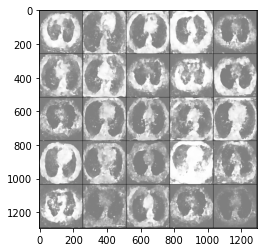

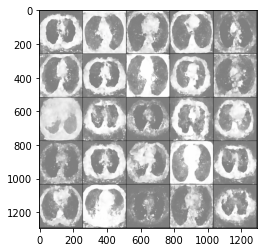

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


NON-COVID-19 Images, origianl images


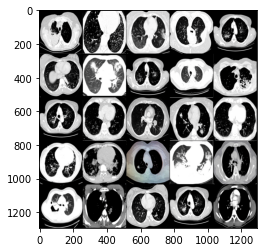

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


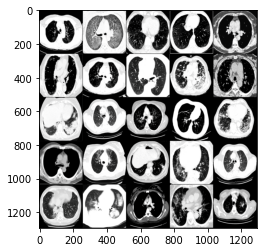

POSITIVE COVID-19 Images, reconstructed


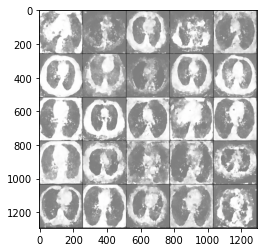

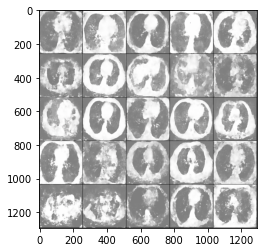

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


POSITIVE COVID-19 Images, origianl images


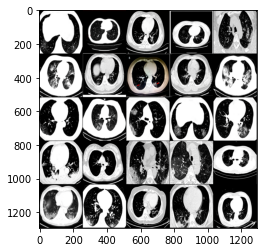

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


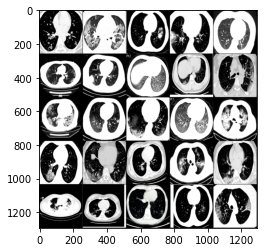

In [55]:
# settings = {"latent":20, "nE":200, "bs":64, "cap":64, "lr":1e-3, "wd":1e-5, "vb":0.5}
# settings = {"latent":20, "nE":100, "bs":64, "cap":64, "lr":1e-3, "wd":1e-5, "vb":1}
settings = {"latent":20, "nE":1000, "bs":64, "cap":64, "lr":1e-3, "wd":1e-5, "vb":0.5}
best_model_wts = f'../model_weights/VAE_raw/n_{settings["nE"]}.ld_{settings["latent"]}.lr_{settings["lr"]}.vb_{settings["vb"]}.last_model.wts'

test_data = CovidCTDataset(path, with_aug=False, with_cgan=False, split = 'test')

torch.utils.data.DataLoader(test_data, shuffle = True, batch_size = settings["bs"])

print(settings)

train_loader = torch.utils.data.DataLoader(test_data, batch_size=settings["bs"], shuffle=True, num_workers=0)

vae = setup_model(settings["cap"], settings["latent"])

vae.load_state_dict(torch.load(best_model_wts, map_location=torch.device('cpu')))

vae.eval()

sampled_images_noncov = []
real_noncov = []
sampled_images_cov = []
real_cov = []

for image_batch, _ in train_loader:
            
    image_batch = image_batch.to(device)

    # vae reconstruction
    image_batch_recon, latent_mu, latent_logvar = vae(image_batch)

    # covid is 1, noncovid is 0
    for real, im, lab in zip(image_batch, image_batch_recon, _):
        # print(im.shape)
        if lab.item() == 0:
            sampled_images_noncov.append(im)
            real_noncov.append(real)
        else:
            sampled_images_cov.append(im)
            real_cov.append(real)

print('NON-COVID-19 Images, reconstructed')
show_image(torch.stack(sampled_images_noncov)[0:26], num_images=25)
show_image(torch.stack(sampled_images_noncov)[26:51], num_images=25)
print('NON-COVID-19 Images, origianl images')
show_image(torch.stack(real_noncov)[0:26], num_images=25)
show_image(torch.stack(real_noncov)[26:51], num_images=25)


print('POSITIVE COVID-19 Images, reconstructed')
show_image(torch.stack(sampled_images_cov)[0:26], num_images=25)
show_image(torch.stack(sampled_images_cov)[26:51], num_images=25)
print('POSITIVE COVID-19 Images, origianl images')
show_image(torch.stack(real_cov)[0:26], num_images=25)
show_image(torch.stack(real_cov)[26:51], num_images=25)